In [2]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd

import openpyxl

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.agent import Memory, ActionValueNetwork, GaussianPolicyNetwork, GaussianBinomialPolicyNetwork, ActorCriticAgent
from market_simulation_study.environment import MarketEnvironment

from torch.optim import Adam

from codelib.plotting import dist_vs_normal_plot, volume_contribution_plot, DefaultStyle, default_colors
sns.set_theme("paper","whitegrid")
DefaultStyle()
"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation 


## Setup

In [3]:
# Declare parameters
n_random_agents = 4
n_investor_agents = 2
n_trend_agents = 4
n_mm_agents = 15
n_rl_agents = 1

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

time_periods = 1000

price_list = [100 + np.random.normal(scale = 0.01) for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99.5
mean_sell_price = 100.5
delta = 1
atp = 0
total_buy_volume = 0
total_sell_volume = 0

state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage, 
          'total_buy_volume': total_buy_volume, 'total_sell_volume': total_sell_volume}#, 'all_traded_prices': atp}

def reset1():
    agents = []

    investor_agents = []

    inv_intensity = 0.02

    if n_investor_agents >= 1:
        investor_agents.append(InvestorAgent(agent_id = 0,
                                         delta = delta,
                                         intensity = inv_intensity / 4,
                                         buy_price_margin = 0.0025,
                                         sell_price_margin = 0.010,
                                         buy_volume = 15,
                                         sell_volume = 30, 
                                         n_orders = 10))
    if n_investor_agents == 2:  
        investor_agents.append(InvestorAgent(agent_id = 1,
                                             delta = delta,
                                             intensity = inv_intensity / 2,
                                             n_orders = 6,
                                             buy_price_margin  = 0.005,
                                             sell_price_margin = 0.020,
                                             buy_volume = 25,
                                             sell_volume = 50,
                                             can_short = True))

    random_agents = [RandomAgent(agent_id = j + n_investor_agents,
                                 delta = delta,
                                 noise_range = (0.0001, 0.0003),
                                 mid_price_noise = 0.0025,
                                 n_coin_flips = 3, 
                                 coin_bias_sell = 0.5,
                                 coin_bias_buy = 0.5) for j in range(n_random_agents)]

    trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                     delta = delta,
                                      moving_average_one = np.random.randint(10, 15),
                                      moving_average_two = np.random.randint(20, 30),
                                      price_margin = 0.005) for j in range(n_trend_agents)]

    mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                                  delta = delta,
                                  gamma = 0.00005,
                                  gamma2 = np.random.uniform(0.5, 0.75), #np.random.randint(1, 1),
                                  spread_zero = np.random.uniform(0.1, 0.1), 
                                  n_volume = 3) for j in range(n_mm_agents)]


    agents.append(investor_agents)
    agents.append(random_agents)
    agents.append(trend_agents)
    agents.append(mm_agents)

    return agents

agents = reset1()

In [4]:
#####################
# PARAMETERS
#####################
"""Neural Networks"""
max_action_value = 0.025  # Prices
min_action_value = -0.025  # Prices
max_action_value_two = 5  # Volumes
min_action_value_two = 0  # Volumes

action_dims = 4
state_dims = 12
fc1_dims = 256
fc2_dims = 256
learning_rate = 3e-4

batch_size = 5
n_gradient_steps_per_update = 1

"""RL Agent"""
discount_factor = 0.95
agent_id = n_random_agents + n_investor_agents + n_trend_agents + n_mm_agents
def reset2(agents):
    ######################
    # AGENT INITIALIZATION
    ######################
    # policy = GaussianPolicyNetwork(max_action_value     = max_action_value,
    #                                min_action_value     = min_action_value,
    #                                max_action_value_two = max_action_value_two,
    #                                min_action_value_two = min_action_value_two,
    #                                input_dims           = state_dims,
    #                                action_dims          = action_dims,
    #                                fc1_dims             = fc1_dims,
    #                                fc2_dims             = fc2_dims)

    policy = GaussianBinomialPolicyNetwork(max_action_value     = max_action_value,
                                   min_action_value     = min_action_value,
                                   max_action_value_two = max_action_value_two,
                                   min_action_value_two = min_action_value_two,
                                   input_dims           = state_dims,
                                   action_dims          = action_dims,
                                   fc1_dims             = fc1_dims,
                                   fc2_dims             = fc2_dims,
                                   sigma                = 0.0025,
                                   name                 = 'policy_2404_day'
                                   )

    policy_optimiser = Adam(policy.parameters(), lr = learning_rate)

    qf = ActionValueNetwork(input_dims = state_dims + action_dims,
                            fc1_dims = fc1_dims,
                           fc2_dims = fc2_dims,
                           name = 'qf_2404_day')
    qf_optimiser = Adam(qf.parameters(), lr = learning_rate)

    vf = ActionValueNetwork(input_dims = state_dims,
                            name = 'vf_2404_day')
    vf_optimiser = Adam(vf.parameters(), lr = learning_rate)

    rl_agents = [ActorCriticAgent(policy           = policy, 
                                  policy_optimiser = policy_optimiser,
                                  qf               = qf,
                                  qf_optimiser     = qf_optimiser,
                                  vf               = vf,
                                  vf_optimiser     = vf_optimiser, 
                                  discount_factor  = discount_factor, 
                                  agent_id         = agent_id,
                                  init_state       = state0,
                                  batch_size       = batch_size,
                                 position_penalty  = 0.1)]

    agents.append(rl_agents)
    
    agents = [item for sublist in agents for item in sublist]
    
    return agents

agents = reset2(agents)

### Initialize agents

In [5]:
# env = MarketEnvironment(state0, use_last_traded_price = True)

# agents = [item for sublist in agents for item in sublist]

# # Initialize agents
# for j in range(n_agents):
#         agents[j].update(state0)

In [6]:
agents = reset1()
agents = reset2(agents)

## Run simulation

KeyboardInterrupt: 

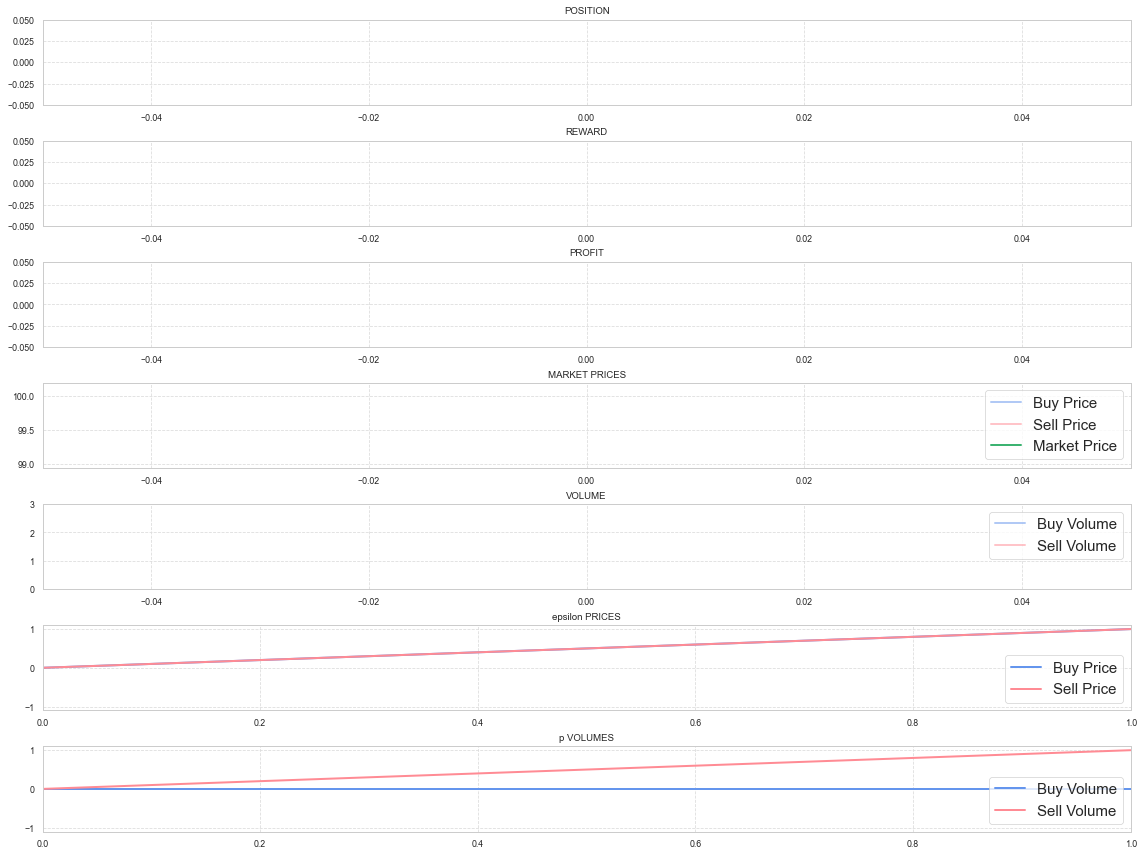

In [8]:
time_periods = 500
n_episodes = 100000
rl_profit = []
market_prices = []
inv1_pos = []
inv2_pos = []
market_volume = []
atps = np.array([np.nan])
stack_autocorrels = False

save_count = 10
mm_volumes = np.zeros(int(time_periods / save_count))
random_volumes = np.zeros(int(time_periods / save_count))
investor_volumes = np.zeros(int(time_periods / save_count))
trend_volumes = np.zeros(int(time_periods / save_count))
rl_volumes = np.zeros(int(time_periods / save_count))

mm_pnls = np.zeros(int(time_periods / save_count))
random_pnls = np.zeros(int(time_periods / save_count))
investor_pnls = np.zeros(int(time_periods / save_count))
trend_pnls = np.zeros(int(time_periods / save_count))
rl_pnls = np.zeros(int(time_periods / save_count))

bps = []
sps = []

#pd.DataFrame([stacked_volumes, stacked_volumes])
all_traded_volumes = np.zeros((n_episodes, 5, int(time_periods / save_count)))
all_pnls_volumes = np.zeros((n_episodes, 5, int(time_periods / save_count)))
all_policy_loss = []
all_qf_loss = []
all_vf_loss = []
all_rl_end_rewards = np.zeros(n_episodes)

fig, ax = plt.subplots(7, 1, figsize = (16, 12))
fig.tight_layout()
for episode in range(n_episodes):
    # TO REDUCE RUNTIME RESET AGENTS AND LOAD MODELS
    if episode % 5 == 0 and episode != 0:
        all_vf_loss.append(agents[-1].vf_loss_mem)
        all_qf_loss.append(agents[-1].qf_loss_mem)
        all_policy_loss.append(agents[-1].policy_loss_mem)
        agents = reset1()
        agents = reset2(agents)
        #agents[-1].load_models("nn_models/policy_nn_nn", "nn_models/qf_nn_nn", "nn_models/vf_nn_nn")
        agents[-1].load_models()
    agents[-1].reset()
    env = MarketEnvironment(state0, use_last_traded_price = True)
    # Initialize agents
    for j in range(n_agents):
            agents[j].reset()
            agents[j].update(state0)
    
    
    
    # START EPISODE
    rl_profit = []
    rl_reward = []
    rl_positions = []
    agent_class = []
    rl_buy_prices = []
    rl_sell_prices = []
    rl_buy_volume = []
    rl_sell_volume = []
    market_prices = []
    mus = np.array([[0, 0, 0, 0]])
    for time in range(time_periods):

        agents, state = env.step(agents)

        for j in range(n_agents):
            agents[j].update(state)


        #################################
        # RL AGENT UPDATE
        #################################
        if time % 10 == 0 or episode < 10:
            agents[-1].update(state, exploration_mode = True)
        else:
            agents[-1].update(state, exploration_mode = False)

        if time >= 20:
            if time % 10 == 0:
                for _ in range(n_gradient_steps_per_update):
                    agents[-1].score_gradient_descent()

        # Store RL DATA
        agent_class.append(agents[-1].agent_class)
        rl_profit.append(agents[-1].pnl)
        rl_reward.append(agents[-1].memory.rewards[-1].detach().numpy())
        rl_positions.append(agents[-1].position)
        rl_sell_prices.append(agents[-1].sell_price)
        rl_buy_prices.append(agents[-1].buy_price)
        rl_sell_volume.append(agents[-1].sell_volume)
        rl_buy_volume.append(agents[-1].buy_volume)
        
        # mus
        #mus.append([agents[-1].mu1, agents[-1].mu2, agents[-1].mu3, agents[-1].mu4])
        mus = np.vstack((mus, [agents[-1].mu1.detach().numpy(), agents[-1].mu2.detach().numpy(), 
                               agents[-1].mu3.detach().numpy(), agents[-1].mu4.detach().numpy()]))
        
        ########################################
        # PRINT RUNTIME
        ########################################

        j = (time + 1) / time_periods
        sys.stdout.write('\r'.center(65))
        sys.stdout.write(f"EPISODE {episode} - %d%%".center(65) % (100*j))
        sys.stdout.flush()
        
        #########################################
        # SAVE VOLUMES
        #########################################

        if save_count:
            
            if time % save_count == 0:
                for agent in agents:
                    agent.calculate_profit_and_loss(state)
                    if agent.agent_class == "MM":
                        mm_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        mm_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Random":
                        random_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        random_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Investor":
                        investor_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        investor_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Trend":
                        trend_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        trend_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "ActorCritic":
                        rl_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        rl_pnls[int(time / save_count)] += agent.pnl
            
        #########################################
        # UPDATE PLOTS
        #########################################

        inv1_pos.append(agents[0].position)
        inv2_pos.append(agents[1].position)
        market_volume.append(state["volume"])
        market_prices.append(state["market_prices"][-1])
        atps = 0#np.hstack((atps, state["all_traded_prices"]))
        
        
        #################################
        # VISUALISATION
        #################################
        
        if time % 475 == 0:
            clear_output()
            ax[0].cla()
            ax[0].plot(rl_positions, label = "Positions")
            ax[0].set(title = "POSITION")
            
            ax[1].cla()
            ax[1].set(title = "REWARD")
            ax[1].plot(rl_reward, label = "reward")
            
            ax[2].cla()
            ax[2].set(title = "PROFIT")
            ax[2].plot(rl_profit, label = "Profit")

            ax[3].cla()
            ax[3].plot(rl_buy_prices, label = "Buy Price", alpha = 0.5)
            ax[3].plot(rl_sell_prices, label = "Sell Price", alpha = 0.5)
            ax[3].plot(market_prices, label = "Market Price")
            ax[3].set(title = "MARKET PRICES")
            ax[3].legend()
            
            ax[4].cla()
            ax[4].plot(rl_buy_volume, label = "Buy Volume", alpha = 0.5)
            ax[4].plot(rl_sell_volume, label = "Sell Volume", alpha = 0.5)
            ax[4].set(title = "VOLUME")
            ax[4].legend()
            
            ax[5].cla()
            labs = ["Buy Price", "Sell Price"]
            for i in range(2):    
                ax[5].plot(mus[:, i], label = labs[i])
            ax[5].set(title = "epsilon PRICES")
            ax[5].legend()
            ax[5].set_ylim(-1.1,1.1)
            
            ax[6].cla()
            labs2 = ["Buy Volume", "Sell Volume"]
            for j in range(2):
                ax[6].plot(mus[:, 2 + j], label = labs2[j])
            ax[6].legend()
            ax[6].set_ylim(-1.1,1.1)
            ax[6].set(title = "p VOLUMES")
            display(fig)
    
    #########################################
    # END OF EPISODE
    #########################################
    if stack_autocorrels:
        mp = pd.DataFrame(atps)
        #mp = pd.DataFrame({"return": market_prices})
        returns = (mp / mp.shift(1)  - 1).dropna()
        #fig1, ax1 = plt.subplots()
        #ax1.set(xlim = (0, 10))
        if episode == 0:
            # Stack returns
            all_stacked_returns = returns.values.flatten()
            # stack autocorrels
            #autocorrel_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #autocorrel_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
        else:
            # stack returns
            all_stacked_returns = np.hstack((all_stacked_returns, returns.values.flatten()))
            # stack autocorrels
            #temp_auto_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #print("1", autocorrel_returns)
            #print("2", temp_auto_returns)
            #autocorrel_returns = np.vstack((autocorrel_returns, temp_auto_returns))
            #temp_auto_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
            #autocorrel_absreturns = np.vstack((autocorrel_absreturns, temp_auto_absreturns))
       # ax1.cla()
    
    
    
    mm_volumes[1:] = mm_volumes[1:] - mm_volumes[:-1]
    random_volumes[1:] = random_volumes[1:] - random_volumes[:-1]
    investor_volumes[1:] = investor_volumes[1:] - investor_volumes[:-1]
    trend_volumes[1:] = trend_volumes[1:] - trend_volumes[:-1]
    rl_volumes[1:] = rl_volumes[1:] - rl_volumes[:-1]
    total_volumes = mm_volumes + investor_volumes + trend_volumes + random_volumes + rl_volumes

    mm_volumes = mm_volumes / total_volumes
    investor_volumes = investor_volumes / total_volumes
    trend_volumes = trend_volumes / total_volumes
    random_volumes = random_volumes / total_volumes
    rl_volumes = rl_volumes / total_volumes

    stacked_volumes = np.vstack((investor_volumes, trend_volumes, random_volumes, mm_volumes, rl_volumes))
    stacked_pnls = np.vstack((investor_pnls / n_investor_agents, trend_pnls / n_trend_agents, 
                              random_pnls / n_random_agents, mm_pnls / n_mm_agents,
                             rl_pnls))
    
    all_traded_volumes[episode,:,:] = stacked_volumes
    all_pnls_volumes[episode,:,:] = stacked_pnls
    all_rl_end_rewards[episode] = agents[-1].memory.rewards[-1].detach().numpy()[0]
    agents[-1].save_models()
    
    out = {'volumes': all_traded_volumes, 'pnls': all_pnls_volumes,
          'end_rewards': all_rl_end_rewards, 'vf_loss': all_vf_loss,
          'qf_loss': all_qf_loss, 'policy_loss': all_policy_loss}

    np.save('rl_market_experiment_data.npy', out) 

    
time_points = np.linspace(save_count, time_periods, int(time_periods / save_count))

#save_state_space
#agents[n_agents - 1].save_state_space()

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Cumulative Return')]

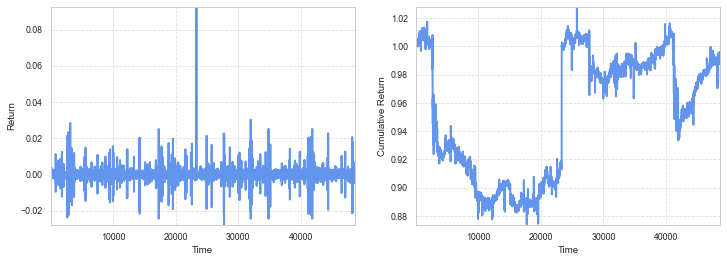

In [70]:
#mp = pd.DataFrame(market_prices[100:])
mp = pd.DataFrame(atps)
#mp = pd.DataFrame({"return": market_prices})
returns = (mp / mp.shift(1)  - 1).dropna() 
#returns = returns[abs(returns.values) <= 0.0125]
cum_ret = (returns + 1).cumprod()
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(ylabel = "Return", xlabel = "Time")
ax[1].plot(cum_ret)
ax[1].set(xlabel = "Time", ylabel = "Cumulative Return")

#plt.savefig("plots/returns_cumreturns_4.png")

# Stylized Facts Comparison

## returns

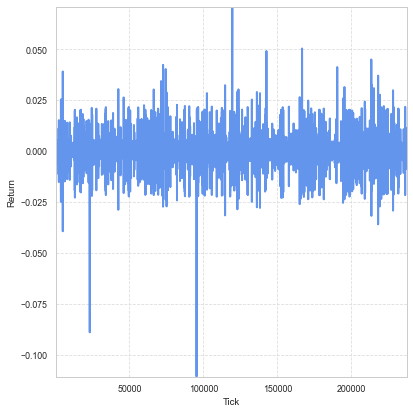

In [8]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(returns)
ax.set(ylabel = "Return", xlabel = "Tick")
#ax.set(xlim = (-0.005, 0.005))
fig.tight_layout()
#ret = "returns_bfrl_6"
#plt.savefig(f"plots/{ret}.png")

### Heavy Tails

In [9]:
all_stacked_returns.shape

(1306994,)

In [10]:
from codelib.stats import weighted_kurtosis

In [11]:
test_data = pd.read_parquet('abm_calibration/ef805fd82ff54fadb363094e3b122ab9.parquet', engine='pyarrow')
test_data
spy_prices = test_data[["time_id", "price"]]
spy_prices = spy_prices.set_index("time_id", drop = True)
spy_returns = (spy_prices["price"] / spy_prices["price"].shift() - 1).dropna()

In [12]:
compare_returns = pd.DataFrame(spy_returns)
x_vals, y_vals = sns.kdeplot(x=returns.values.flatten(), color="cornflowerblue",
                                 weights=np.ones_like(returns.values.flatten()), label="Returns",
                                 alpha=1, ax=ax).get_lines()[0].get_data()
ax.cla()
x_vals2, y_vals2 = sns.kdeplot(x=compare_returns.values.flatten(), color="cornflowerblue",
                                       weights=np.ones_like(compare_returns.values.flatten()), label="Returns",
                                       alpha=1, ax=ax).get_lines()[0].get_data()

In [ ]:
ax.cla()
x_vals2, y_vals2 = sns.kdeplot(x=compare_returns.values.flatten(), color="cornflowerblue",
                                       weights=np.ones_like(compare_returns.values.flatten()), label="Returns",
                                       alpha=1, ax=ax, gridsize = 500).get_lines()[0].get_data()

In [ ]:
ax.cla()
x_vals, y_vals = sns.kdeplot(x=returns.values.flatten(), color="cornflowerblue",
                                 weights=np.ones_like(returns.values.flatten()), label="Returns",
                                 alpha=1, ax=ax, gridsize = 500).get_lines()[0].get_data()

In [ ]:
kurt = weighted_kurtosis(returns, wts=np.ones_like(returns))
kurt2 = weighted_kurtosis(compare_returns, wts = np.ones_like(compare_returns))
loc = [0.15, 0.9]


fig, ax = plt.subplots(figsize = (6, 6))
ax.set(xlim = (-0.01, 0.01))
ax.plot(x_vals, y_vals / y_vals.max(), lw = "1", alpha = 0.95, label = "ABM Returns")
ax.plot(x_vals2, y_vals2 / y_vals.max(), ls = "--", lw = "1", alpha = 1, label = "Real Data")

ax.text(loc[0]+0.085, loc[1], f"kurt sim = {kurt:.1f}", horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax.text(loc[0]+0.1, loc[1] - 0.05, f"kurt real = {kurt2:.1f}", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
ax.set(xlabel = "Return", ylabel = "Density")
#plt.savefig("plots/abm_compare_dist_ljb.png")

In [ ]:
kurt

### Volatility Clustering

In [138]:
acf(abs(returns), nlags = 1)[1:]

array([0.30149968])

In [ ]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(np.abs(returns[1:]), lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 40), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
vol_clust_name = "vol_cluster_bfrl_8"
#plt.savefig(f"plots/{vol_clust_name}_ljb.png")

### Autocorrel of returns

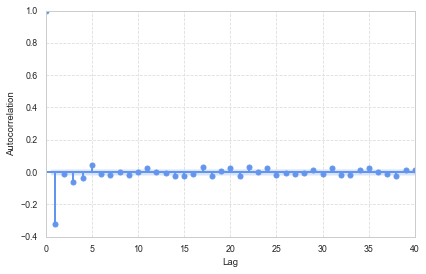

In [124]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(returns[1:], lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 40), ylim = (-0.4, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
auto_ret_name = "auto_returns_bfrl_8"
#plt.savefig(f"plots/{auto_ret_name}_ljb.png")

# Volume Contribution

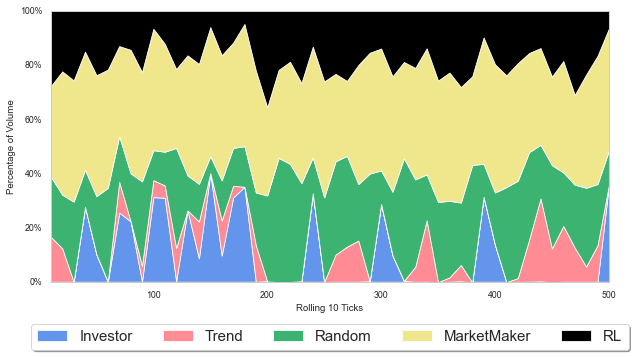

In [94]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points, stacked_volumes, ax = ax, n_ticks = save_count,  rl_agent = True)
volume_name = "volume_graph_6"
#plt.savefig(f"plots/{volume_name}_ljb.png")

## Test MMS

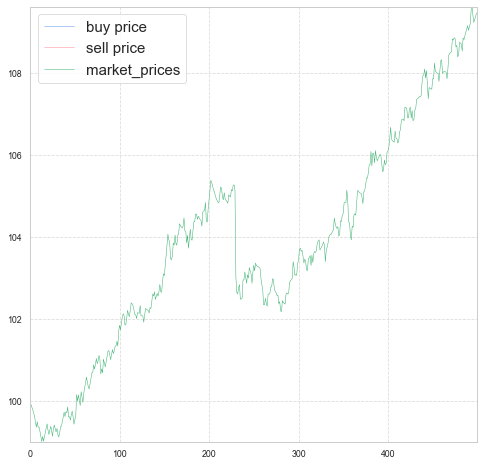

In [82]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(bps, label = "buy price", lw = 0.5)
ax.plot(sps, label = "sell price", lw = 0.5)
ax.plot(state["market_prices"][100:], label = "market_prices", lw = 0.5)
ax.legend()
#ax.set_xlim(200, 250)
#ax.set_ylim(108, 110)

<AxesSubplot:>

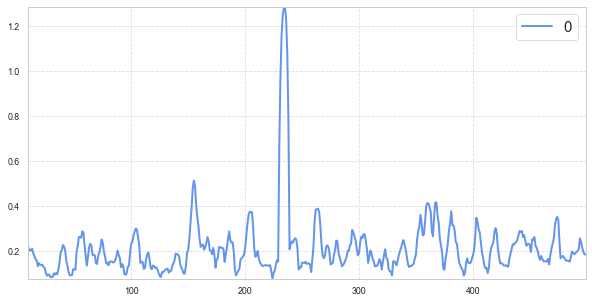

In [83]:
fig, ax = plt.subplots(figsize = (10, 5))
pd.DataFrame(state["market_prices"][100:]).rolling(window = 10).std().plot(ax = ax)

# PnL

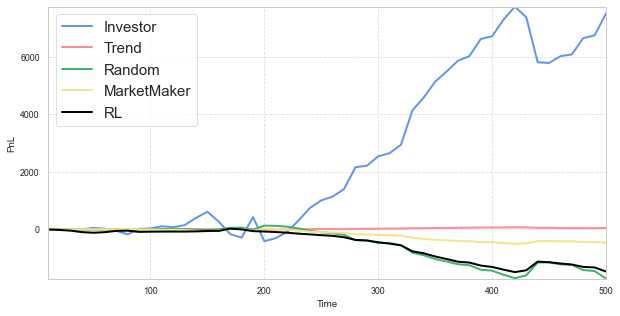

In [95]:
fig, ax = plt.subplots(figsize = (10, 5))
labs = ["Investor", "Trend", "Random", "MarketMaker", "RL"]
for j in range(5):
    ax.plot(time_points, stacked_pnls[j, :], label = labs[j])
ax.set(xlabel = "Time", ylabel = "PnL")
ax.legend()
#plt.savefig("plots/pnl_bfrl_ljb.png")

# Performance overview

In [96]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    #stats_df = stats_df.append(df_temp)
    stats_df = pd.concat([stats_df, df_temp])

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
#np.corrcoef(stats_df.PNL, stats_df.latency)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -8.640199666842818e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
20,20,MM,-17.0,-92.035312,0.500458
16,16,MM,-15.0,-154.373154,0.502120
11,11,MM,-13.0,-119.772838,0.503737
13,13,MM,-16.0,-136.601805,0.520665
18,18,MM,-13.0,-147.582429,0.578362
10,10,MM,-15.0,-127.207351,0.595850
19,19,MM,-16.0,-135.837113,0.625436
23,23,MM,-16.0,-112.746441,0.639981
15,15,MM,-12.0,-117.886576,0.646935
12,12,MM,-15.0,-116.097548,0.746548


class
ActorCritic    -557.281905
Investor       1955.813357
MM             -128.122147
Random         -393.839604
Trend            35.711453
Name: PNL, dtype: float64

# LOSS FUNCTIONS

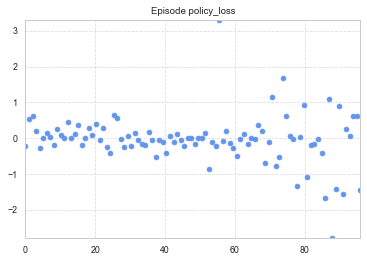

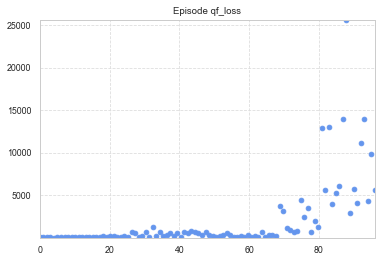

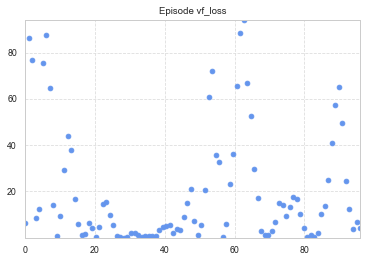

In [30]:
plt.scatter(y = agents[-1].policy_loss_mem, x = np.linspace(0, len(agents[-1].policy_loss_mem), len(agents[-1].policy_loss_mem)))
plt.title("Episode policy_loss")
plt.show()
plt.scatter(y = agents[-1].qf_loss_mem, x = np.linspace(0, len(agents[-1].qf_loss_mem), len(agents[-1].qf_loss_mem)))
plt.title("Episode qf_loss")
plt.show()
plt.scatter(y = agents[-1].vf_loss_mem, x = np.linspace(0, len(agents[-1].vf_loss_mem), len(agents[-1].vf_loss_mem)))
plt.title("Episode vf_loss")
plt.show()

# DATA FROM EXPERIMENT

In [10]:
rf_data = np.load('rl_market_experiment_data.npy',allow_pickle='TRUE').item()

AttributeError: 'dict' object has no attribute 'shape'

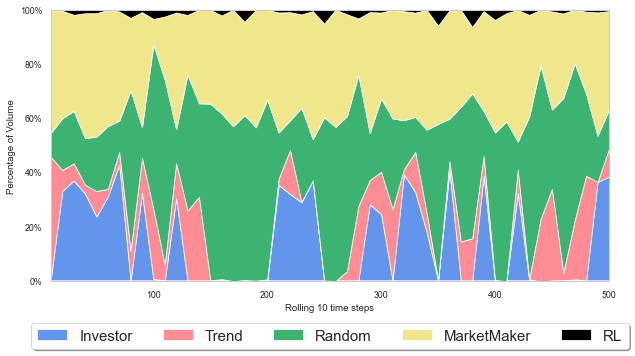

In [18]:
time_points = np.linspace(save_count, time_periods, int(time_periods / save_count))
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points, rf_data['volumes'][151,:,:], ax = ax, n_ticks = save_count,  rl_agent = True)
volume_name = "volume_graph_6"

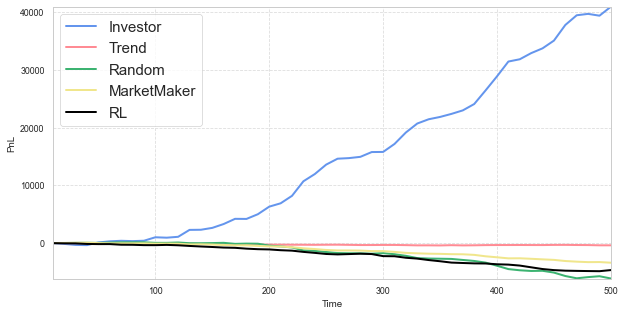

In [26]:
fig, ax = plt.subplots(figsize = (10, 5))
labs = ["Investor", "Trend", "Random", "MarketMaker", "RL"]
for j in range(5):
    ax.plot(time_points, rf_data['pnls'][50,j, :], label = labs[j])
ax.set(xlabel = "Time", ylabel = "PnL")
ax.legend()

In [36]:
rf_data.keys()

dict_keys(['volumes', 'pnls', 'end_rewards', 'vf_loss', 'qf_loss', 'policy_loss'])